## A simple demostration of how to run

In [ ]:
# cleaning
# %rm -rf /content/3DDFA_V2

In [ ]:
# if not clone, clone it
%cd /content
!git clone https://github.com/cleardusk/3DDFA_V2.git
%cd 3DDFA_V2

/content
Cloning into '3DDFA_V2'...
remote: Enumerating objects: 706, done.
remote: Total 706 (delta 0), reused 0 (delta 0), pack-reused 706
Receiving objects: 100% (706/706), 74.78 MiB | 26.84 MiB/s, done.
Resolving deltas: 100% (366/366), done.
/content/3DDFA_V2


In [ ]:
!sh ./build.sh

running build_ext
cythoning nms/cpu_nms.pyx to nms/cpu_nms.c
/usr/local/lib/python3.8/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/3DDFA_V2/FaceBoxes/utils/nms/cpu_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'nms.cpu_nms' extension
creating build
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/nms
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.8/dist-packages/numpy/core/include -I/usr/include/python3.8 -c nms/cpu_nms.c -o build/temp.linux-x86_64-3.8/nms/cpu_nms.o -Wno-cpp -Wno-unused-function
nms/cpu_nms.c: In function ‘__pyx_pf_3nms_7cpu_nms_2cpu_soft_nms’:
nms/cp

In [ ]:
# before import, make sure FaceBoxes and Sim3DR are built successfully, e.g.,

import cv2
import yaml

from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.render import render
from utils.depth import depth
from utils.pncc import pncc
from utils.uv import uv_tex
from utils.pose import viz_pose
from utils.serialization import ser_to_ply, ser_to_obj
from utils.functions import draw_landmarks, get_suffix

import matplotlib.pyplot as plt
from skimage import io
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load configs

In [ ]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    !pip install onnxruntime
    
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX

    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    face_boxes = FaceBoxes()
    tddfa = TDDFA(gpu_mode=False, **cfg)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 5.1 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 


/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:2020: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:2020: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input output
  warnings.warn(


Convert /content/3DDFA_V2/FaceBoxes/weights/FaceBoxesProd.pth to /content/3DDFA_V2/FaceBoxes/weights/FaceBoxesProd.onnx done.


/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:2020: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input alpha_shp
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/onnx/utils.py:2020: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input alpha_exp
  warnings.warn(


Convert configs/bfm_noneck_v3.pkl to configs/bfm_noneck_v3.onnx done.
weights/mb1_120x120.onnx does not exist, try to convert the `.pth` version to `.onnx` online
Convert weights/mb1_120x120.pth to weights/mb1_120x120.onnx done.


In [13]:
root = '/content/drive/My Drive/CIS1070/DATASET'
artists = ['natural faces', 'Fernando Botero(naive art primitivism)', 'Frida Kahlo(surrealism)', 'Kuzma Petrov Vodkin(symbolism)', 'Vladimir Borovikovsky(neoclassicism)']
# 'Jan van Eyck', 'Édouard Manet' , 'Giotto''Jean-Honoré Fragonard'
all_param = []
for artist in artists:
  dir = os.path.join(root, artist)
  files = glob(dir + '/*')
  
  artist_param = []
  for file in files:
    img = io.imread(file)
    img = img[..., ::-1] 

    max_shape = max(img.shape)
    if max_shape > 2000:
      ratio = 2000. / max_shape
      img = cv2.resize(img, None, fx=ratio, fy=ratio)

    boxes = face_boxes(img)
    param_lst, roi_box_lst = tddfa(img, boxes)

    if len(param_lst) <= 0:
      continue

    param = param_lst[0]
    shape_param = param[12:12+40]
    artist_param.append(shape_param)

  all_param.append(artist_param)


In [14]:
from sklearn.manifold import TSNE
import torch
import numpy as np

In [15]:
total_tensor = [np.stack(i).squeeze() for i in all_param]
total_tensor = np.concatenate(total_tensor)

sample_size = [len(i) for i in all_param]
sample_size = np.array(sample_size)
print(sample_size)

[188 122  50 146  98]


In [27]:
def tsne(features, n_components=2, perplexity=15, n_iter=1000):
    np.random.seed(0)
    X_embedded = TSNE(n_components = n_components, 
                      perplexity = perplexity, 
                      n_iter = n_iter).fit_transform(features)

    return X_embedded

perplexity = 15. # 5~60
embedded = tsne(total_tensor, n_components=2, perplexity=perplexity)
embedded = [embedded[sample_size[:i].sum():sample_size[:i+1].sum()] for i in range(len(sample_size))]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


15.0


[]

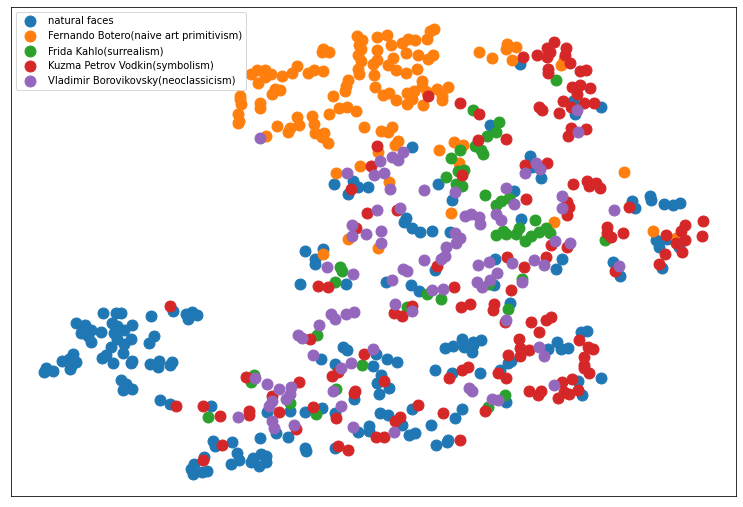

In [30]:
	fig ,ax = plt.subplots(figsize=[13,9])
	for i, x in enumerate(embedded):
	    ax.scatter(x[:,0], x[:,1], marker='o', s=120, label = artists[i])
	
	print(perplexity)
	ax.legend()
	ax.set_yticks([])
	ax.set_xticks([])

In [ ]:
#Green stands for Giotto, Blue stands for Jean-Honoré Fragonard and orange stands for Paul Gauguin

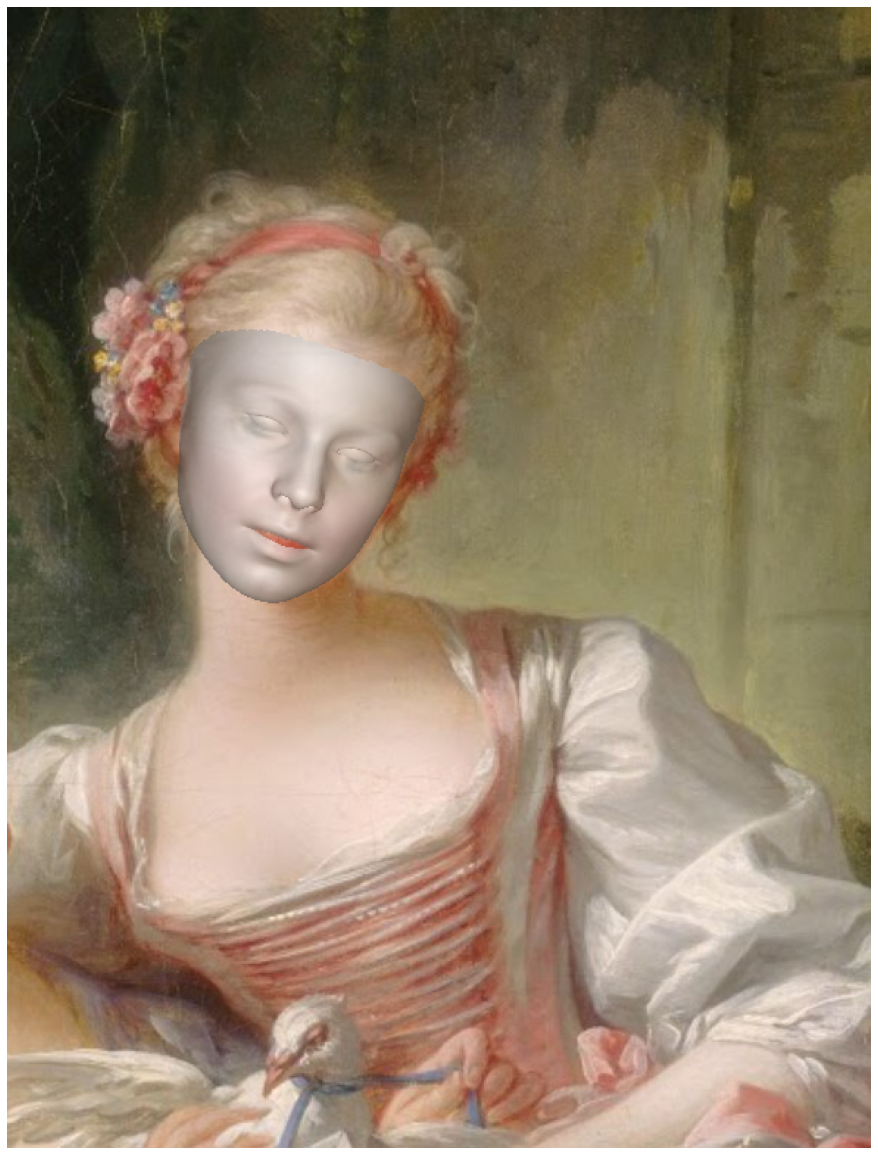

In [ ]:
# reconstruct vertices and visualizing dense landmarks
dense_flag = True
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
render(img, ver_lst, tddfa.tri, alpha=0.6, show_flag=True);